In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2 

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv3D ,MaxPooling3D,UpSampling3D
from tensorflow.keras.models import Model
from keras import backend as K
import imageio
import glob 
import os
import cv2
import numpy as np
from keras import regularizers
from keras.datasets import mnist

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard,CSVLogger

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

img_width=512 # 2048
img_height=512 # 2048

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
defect_folder= '/content/drive/MyDrive/dataset_train/spray_defects'
normal_folder= '/content/drive/MyDrive/dataset_train/normal'

In [4]:
import tensorflow as tf
from tensorflow import keras

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.99
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
def normalize(img):
    min = img.min()
    max = img.max()
    return 2.0 * (img - min) / (max - min) - 1.0

In [6]:
def norm_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if not filename.startswith('.'):
            img=cv2.imread(os.path.join(folder,filename))[:2048,:2048,:1]#2048
            #print('Original Dimensions : ',img.shape)
            dim = (img_width, img_height)
            resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
            #print('Resized Dimensions : ',resized.shape)
      #      img = cv2.fastNlMeansDenoising(img,50,50,20,21) 
            img = normalize(resized)
            if img is not None:
                images.append(img)
    return images

In [7]:
img_defects_norm=norm_images_from_folder(defect_folder)
img_clean_norm=norm_images_from_folder(normal_folder)

In [8]:
img_all=img_defects_norm+img_clean_norm
Y=[1]*len(img_defects_norm)+[0]*len(img_clean_norm)
np.save("img_all.npy",img_all)
np.save("Y_all.npy",Y)

In [9]:
img_all=np.load("img_all.npy")
Y=np.load("Y_all.npy")

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_all, Y, 
                    test_size=0.2, stratify = Y, random_state=60)

In [11]:

print (X_train.shape)
print (X_test.shape)



(177, 512, 512)
(45, 512, 512)


In [14]:
def create_layers():
  layers = []
  size = 32 
  
  #encoder layers
  for i in range(0, 3):
    x = Conv2D(size, (3, 3), activation='relu', padding='same')
    layers += [x] 
    x = MaxPooling2D((2, 2), padding='same')
    layers += [x]
    size = size // 2
  

  #deocder layers 
  for i in range(0, 3):
    size = size * 2
    if i == 2:
      x = Conv2D(size, (3, 3), activation='relu', padding='same')
    else:
      x = Conv2D(size, (3, 3), activation='relu', padding='same')
    layers += [x]
    x = UpSampling2D((2, 2))
    layers += [x]
    
    
  x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')
  layers += [x]
  
  return layers

def autoencoder():
  input_img = Input(shape=(512, 512, 1))  

  layers = create_layers()

  #create the auto encoder network 
  x = input_img
  for layer in layers:
    x = layer(x)
    
  autoencoder = Model(input_img, x)
  #autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
  autoencoder.compile(optimizer = 'adam', loss = 'mse')
  
  #create the encoder network
  x = input_img
  for layer in layers[0:6]:
    x = layer(x)
    
  encoder = Model(input_img, x)
  
  #create the decoder network
  input_encoded = Input(shape = (64, 64, 8))
  x = input_encoded
  for layer in layers[6:]:
    x = layer(x)

  decoder = Model(input_encoded, x)
  return autoencoder, encoder, decoder 

In [15]:
autoencoder, encoder, decoder = autoencoder()

In [16]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 512, 512, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 16)      4624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 8)         0   

In [17]:
history = autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=3,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/10
59/59 [==============================] - 39s 643ms/step - loss: 0.2842 - val_loss: 0.1734
Epoch 2/10
59/59 [==============================] - 38s 640ms/step - loss: 0.1750 - val_loss: 0.1734
Epoch 3/10
59/59 [==============================] - 38s 644ms/step - loss: 0.1750 - val_loss: 0.1734
Epoch 4/10
59/59 [==============================] - 38s 651ms/step - loss: 0.1750 - val_loss: 0.1734
Epoch 5/10
59/59 [==============================] - 38s 645ms/step - loss: 0.1750 - val_loss: 0.1734
Epoch 6/10
59/59 [==============================] - 38s 649ms/step - loss: 0.1750 - val_loss: 0.1734
Epoch 7/10
59/59 [==============================] - 39s 659ms/step - loss: 0.1750 - val_loss: 0.1734
Epoch 8/10
59/59 [==============================] - 38s 652ms/step - loss: 0.1750 - val_loss: 0.1734
Epoch 9/10
59/59 [==============================] - 39s 658ms/step - loss: 0.1750 - val_loss: 0.1734
Epoch 10/10
59/59 [==============================] - 38s 652ms/step - loss: 0.1750 - val_lo

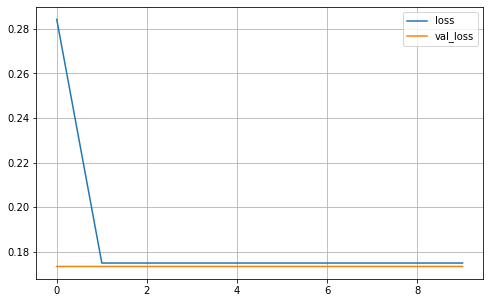

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(0,1)
plt.show()
#adam

In [19]:
def create_layers():
  layers = []
  size = 32 
  
  #encoder layers
  for i in range(0, 3):
    x = Conv2D(size, (3, 3), activation='relu', padding='same')
    layers += [x] 
    x = MaxPooling2D((2, 2), padding='same')
    layers += [x]
    size = size // 2
  

  #deocder layers 
  for i in range(0, 3):
    size = size * 2
    if i == 2:
      x = Conv2D(size, (3, 3), activation='relu', padding='same')
    else:
      x = Conv2D(size, (3, 3), activation='relu', padding='same')
    layers += [x]
    x = UpSampling2D((2, 2))
    layers += [x]
    
    
  x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')
  layers += [x]
  
  return layers

def autoencoder():
  input_img = Input(shape=(512, 512, 1))  

  layers = create_layers()

  #create the auto encoder network 
  x = input_img
  for layer in layers:
    x = layer(x)
    
  autoencoder = Model(input_img, x)
  #autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
  autoencoder.compile(optimizer = 'sgd', loss = 'mse')
  
  #create the encoder network
  x = input_img
  for layer in layers[0:6]:
    x = layer(x)
    
  encoder = Model(input_img, x)
  
  #create the decoder network
  input_encoded = Input(shape = (64, 64, 8))
  x = input_encoded
  for layer in layers[6:]:
    x = layer(x)

  decoder = Model(input_encoded, x)
  return autoencoder, encoder, decoder 

In [20]:
autoencoder, encoder, decoder = autoencoder()

In [21]:
history = autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=3,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/10
59/59 [==============================] - 40s 668ms/step - loss: 0.6202 - val_loss: 0.5441
Epoch 2/10
59/59 [==============================] - 40s 672ms/step - loss: 0.4541 - val_loss: 0.3055
Epoch 3/10
59/59 [==============================] - 40s 674ms/step - loss: 0.2184 - val_loss: 0.1821
Epoch 4/10
59/59 [==============================] - 40s 673ms/step - loss: 0.1803 - val_loss: 0.1766
Epoch 5/10
59/59 [==============================] - 40s 673ms/step - loss: 0.1775 - val_loss: 0.1753
Epoch 6/10
59/59 [==============================] - 40s 674ms/step - loss: 0.1766 - val_loss: 0.1748
Epoch 7/10
59/59 [==============================] - 40s 670ms/step - loss: 0.1762 - val_loss: 0.1745
Epoch 8/10
59/59 [==============================] - 40s 678ms/step - loss: 0.1760 - val_loss: 0.1743
Epoch 9/10
59/59 [==============================] - 40s 675ms/step - loss: 0.1758 - val_loss: 0.1742
Epoch 10/10
59/59 [==============================] - 39s 662ms/step - loss: 0.1757 - val_lo

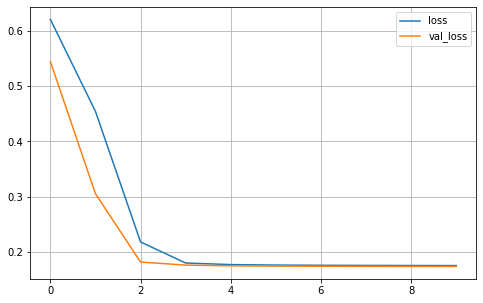

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(0,1)
plt.show()
#sgd